In [1]:
import emlddmm
import numpy as np
import matplotlib.pyplot as plt
from os import sep
from os.path import isdir,join
import json
from glob import glob
from warnings import warn
from difflib import SequenceMatcher

# functionality

We need to input a point in any space (3D or 2D), and output a point in any space (3D or 2D).

For 2D we should be able to go back and forth between pixels and microns.

In [2]:
# each slice will have a vtk displacement field
# this got moved to json
# the json also includes high resolution info
# Hua140/GDM_2022_format_registration_output/registered_histology/atlas_to_registered_histology/transforms_json/'
# where can we get this high resolution information?
# there is a json with fields nx_highres, dx_highres, ox_highres
# for each slice
# 
# how can I get that information for input space?
# 
# there is another folder called atlas_to_histology/ (without the registered)
# there will be a vtk json
# and it will also contain nx_highres, dx_highres, ox_highres for the INPUT histology
#
#

# for high res info I'll do the following
# 1. check if info is in input arguments
# 2. check if any information is in the registration data structure (directory or zip file) in a "transforms_json" file
# 3. do some kind of a database query
# 4. make assumption about the structure, and print a warning


In [3]:
class sloppy_list(list):
    '''A list class where we overload the in operator'''
    
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
    
    def __contains__(self,x):
        status = super().__contains__(x)
        if status:
            return status
        
        print(f'{x} is not in {self}, checking case changes')
        xl = x.lower()
        for a in self:
            if xl == a.lower():
                print('matched')
                return True
        print(f'{x} is not in {self} after ignoring case, checking partial matches')
        xl = x.lower()
        edit_distances = []
        for a in self:
            al = a.lower()
            edits = [e for e in SequenceMatcher(a=a,b=xl).get_opcodes() if e[0] != 'equal']
            print(edits)
            edit_distances.append(len(edits))
        
        if min(edit_distances) == 0 or min(edit_distances) == 1:
            print(f'min edit distance is {min(edit_distances)} returning true')
            return True
        if min(edit_distances) < 0.1*len(x):
            print('min edit distance is les than 10% of length, returning true')
            return True
        
        print('could not match, returning False')
        return False
        
        
    
    def __repr__(self):
        return 'sloppy list: ' + super().__repr__()

In [4]:
a = sloppy_list(['a','b'])
('As' in a) 

As is not in sloppy list: ['a', 'b'], checking case changes
As is not in sloppy list: ['a', 'b'] after ignoring case, checking partial matches
[('insert', 1, 1, 1, 2)]
[('replace', 0, 1, 0, 2)]
min edit distance is 1 returning true


True

In [5]:
# TODO use this function
def pixels_to_microns(x,y,dx,ox):
    '''
    TODO: this is in progress, right now it only supports 2D.  We are not using it currently
    '''
    return x*dx[0] + ox[0], y*dx[1] + ox[1]

In [6]:
# AS OF April 9 2024, this function is not being used
# Load from the .py file instead
def point_mapper(data,
                 x,y,z=None,
                 from_space=None,to_space=None,
                 from_units='microns',to_units='microns',
                 from_ox=None,from_dx=None,
                 to_ox=None,to_dx=None):
    ''' A script to map points or a set of points using strings.
    
    
    Parameters
    ----------
    data : object
        Can be a string that points to a directory, in which case we assume this is pointing to our output directory
        Can be a string that points to a zip file, in which case we assume the file is a zipped version of the output
        Can be a dictionary, in which case we assume it is json with data.                
    x : numpy array
        Should be a number or a list of numbers showing the x coordinate we want to map.
    y : numpy array
        Should be a number or a list of numbers showing the y coordinate we want to map.
        If a list should be the same size as x.
    z : numpy array
        Should be a number or a list of numbers showing the z coordinate we want to map.
        If a list, should be the same size as x.  If not a list, it can be broadcasted to same size as x.
        It could also be a filename or a list of filenames.
    from_units, to_units : str
        Either 'microns' or 'pixels'.  NOTE: pixels not currently supported
        
    from_ox : tuple
        origin.  Location of first pixel in high res file, in units of microns.
        Should be a triple or a double.  They are in the order x,y or x,y,z
    from_dx : tuple
        pixel size.
    
    
    TODO
    ----
    Registration code ALL uses zyx convention (slice, row, column).
    When we write to disk, we use vtk convention, which is xyz.
    Make sure this is all consistent.
    Maybe we can ask the user to input either slice,row,col, or x,y,z, we'll flip them accordingly.
    Make them keywords arguments so we can do them in any order.  We can do this in matlab too.
    
    '''
    
    # parse the directory
    data_is_directory = False
    data_is_zip = False
    data_is_json = False    
    if isinstance(data,str) and isdir(data):
        data_is_directory = True
        data_directory = data
        print('registration data is a directory')
    elif isinstance(data,str) and data.endswith('.zip'):
        print('registration data is a zip file of an output directory')
        raise Exception(f'Only data directories are supported for now')
    elif data_is_json:
        raise Exception('TODO: load the json file into a json')
        data_is_json = True
        data_is_json_file = False
        data_json = dict()        
    else:
        raise Exception(f'Only output directory is currently supported for registration data, but you input {data}')
    
        
    
    # parse the data points xy
    print('printing x')
    if not isinstance(x,np.ndarray):
        x = np.array(x)
        if x.ndim == 0: x = x[None]
    print(x)
    print('printing y')
    if not isinstance(y,np.ndarray):
        y = np.array(y)
        if y.ndim == 0: y = y[None]
    print(y)
    if not np.all(np.array(x.shape)==np.array(y.shape)):
        raise Exception(f'x and y must be the same size, but are {x.shape} and {y.shape}')
    
    
    
    print('printing z')
    z_is_file = False
    z_is_coordinate = False
    if z is not None:   
        if isinstance(z,str):
            z_is_file = True            
            # assume that z is a string pointing to a filename
            # this will only be necessary when mapping from a 2D space.
            print(f'found a filename for z {z}')
            
        elif not isinstance(z,np.ndarray):
            z_is_coordinate = True
            z = np.array(z)
        print(z)
    else:
        warn(f'z is None, setting to zeros coordinate')
        z = np.zeros_like(x)
        print(z)
    
    # parse the from space
    if from_space is None:
        raise Exception('You must specify a from space')
    print(f'From space is {from_space}')        
    # parse the to space
    if to_space is None:
        raise Exception('You must specify a to space')
    print(f'To space is {to_space}')
    # check if spaces are valid
    if from_space == to_space:
        warn(f'from space equals to space, returning identity')
        return x,y,z
    if data_is_directory:
        files = glob(join(data_directory,'*'))
        space_names = []
        for file in files:
            if isdir(file):                
                space_names.append(file.split(sep)[-1])                                
    elif data_is_json:        
        space_names = []
        raise Exception('json data not implemented yet')    
    print(f'identified spaces {space_names}')
    # TODO, allow for sloppy matching
    if from_space not in space_names:
        raise Exception(f'Your from_space {from_space} was not in the availabile spaces {space_names}')
    if to_space not in space_names:
        raise Exception(f'Your to_space {to_space} was not in the available spaces {space_names}')
    
    
    # if necessary we'll convert
    if from_units == 'pixels':
        # TODO
        warn(f'We need to specify spacing and origin in the from space')        
        # for defaults, we will use 0.46 microns
        # and for origin we will have to go to an image
        if from_ox is None or from_dx is None:
            warn(f'Did not specify from ox or from dx so using defaults (dx=0.46um, origin in center of image)')
            dx = [0.46,0.46]
            # to find the origin, we need to find an image to estimate the size
            raise Exception('This default is not done yet, for now you have to specify the origin')            
            
        #raise Exception('conversion from pixels not yet implemented')
        print('converting from pixels to microns in input space')
        print('before')
        print(x,y,z)
        x = x * from_dx[0] + from_ox[0]
        y = y * from_dx[1] + from_ox[1]
        if len(from_dx) > 2 and len(from_ox) > 2:
            z = z * from_dx[2] + from_ox[2]
        print('after')
        print(x,y,z)
    elif from_units == 'microns':
        pass
    else:
        raise Exception(f'Units must be either pixels or microns, but you specified {units}')
        
        
    # find the appropriate transform
    # we look in the folder from_space/to_space_to_from_space/transforms
    if data_is_directory:
        transform_dir = join(data_directory,from_space,to_space + '_to_' + from_space, 'transforms')
        print(f'Found transform dir {transform_dir}')
        files = glob(join(transform_dir,'*matrix.txt'))
        files.sort()
        if files:
            print(f'This is a 2D transform')
            #print(files)
            # to load the matrix we have to get the right z coordinate or filename
            if z_is_file:
                zbool = [z in f for f in files]
                zind = zbool.index(True)
                print(f'Matched to the transformation file {files[zind]}')
                mat = emlddmm.read_matrix_data(files[zind])
                print(mat)
                # transform the coordinates                
                transformed_coords = (mat[:2,:2]@(np.stack([y,x],-1)[...,None]))[...,0] + mat[:2,-1]
                # these coordinates are in microns
                xtransformed = transformed_coords[...,1]
                ytransformed = transformed_coords[...,0]
                # what if we want to convert to pixels
                if to_units == 'pixels':
                    if to_ox is None or to_dx is None:
                        raise Exception('if output space is "pixel" then you must specify both to_ox and to_dx')
                    # inverse of previous function
                    xtransformed = (xtransformed - to_ox[0])/to_dx[0]
                    ytransformed = (ytransformed - to_ox[1])/to_dx[1]
                    
                return xtransformed, ytransformed
            elif z_is_coordinate:
                raise Exception(f'TODO: we have to look up all the files and match one to this coordinate')
                pass                        
            else:
                raise Exception('Something is wrong, z should have been either a file or a coordinate')
        else:
            
            print(f'This is a 3D transform')
            print(f'We load  a vtk file and apply it')
            files = glob(join(transform_dir,'*displacement.vtk'))
            files.sort()            
            print(files)            
            if z_is_file:
                zbool = [z in f for f in files]
                zind = zbool.index(True)
                print(f'Matched to the transformation file {files[zind]}')
                xtform,tform,_,_ = emlddmm.read_data(files[zind])                                
                tform = tform.squeeze()                
                print(tform.shape)
                zcoord = xtform[0]                
                zcoord = np.ones_like(x)*zcoord
                print(zcoord)
                # todo, implement this here instead of import
                from scipy.interpolate import interpn
                zyx = np.stack((zcoord,y,x),-1)
                #print(zyx)
                yx = np.stack((y,x),-1)
                #print(tform.shape)                
                transformed_coords = interpn(xtform[1:],tform.transpose(1,2,0),yx,bounds_error=False,fill_value=0) + zyx
                return transformed_coords
            
            elif z_is_coordinate:
                pass
            else:
                raise Exception('Something is wrong, z should have been either a file or a coordinate')
    else:
        raise Exception('currently only works when data is a directory')

In [7]:
from point_mapper import point_mapper

# First example, mapping from input space to registered space

In [8]:
# we will need to input a list of x,y point
# and some information about the z location, which could be the name of the slice
input_points_xy = ([35.0,45.0,60.0],[40.0,37.0,35.0])
z = 'PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021'

for this example, we use the following input image file
examples/mouse_serial_section_example/NisslDown/PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021.jpg


Text(0.5, 1.0, 'image and points with units of pixels')

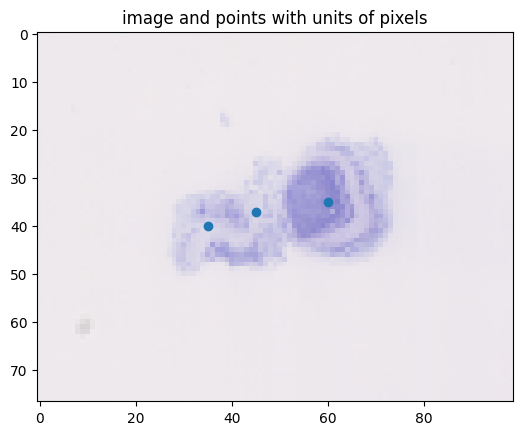

In [9]:
# let's work though this
# first find the image that corresponds to z above
input_image_file = glob('examples/mouse_serial_section_example/NisslDown/' + z + '*.jpg')[0]
print('for this example, we use the following input image file')
print(input_image_file)
J = plt.imread(input_image_file)
fig,ax = plt.subplots()
ax.imshow(J)
# we can draw our points here because this is units of pixels
ax.scatter(input_points_xy[0], input_points_xy[1])
ax.set_title('image and points with units of pixels')
# NOTE, in this example 
# we have placed some landmark points in the middle of the two hemispheres


[58.88 58.88 20.  ] [-2885.1200000000003, -2237.44, -6270.0]
[-824.32 -235.52  647.68] [ 117.76  -58.88 -176.64]


Text(0.5, 1.0, 'image and points with units of microns')

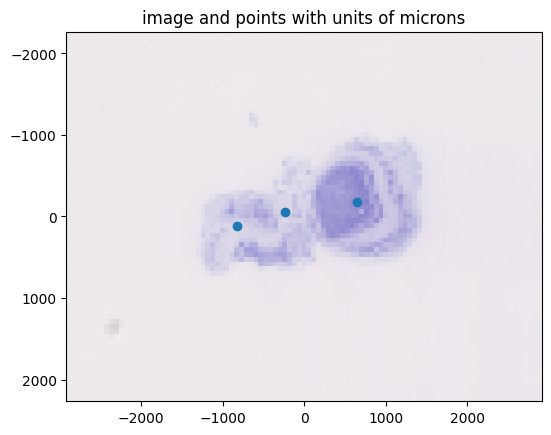

In [10]:
# now we need to find out about the geometry of the INPUT IMAGE file
# we always need origin and pixel size
# 
# 
# in this case the image is in our "standard input structure for command line" so it has a sidecar json file
# in GENERAL, you can get origin and pixel spacing however you want
# NOTE, for input space we don't have any information about where the origin is relative to anatomy
# because we haven't looked at the image and haven't registered.
# but to do mapping we need to assign an xyz coordinate to every pixel
# our convention is that 0,0,0 is the middle of our volume of input slices.
# so the origin is in the center of every 2D slice
with open(input_image_file.replace('.jpg','.json')) as f:
    json_data = json.load( f )
    
dx_input = np.diag(json_data['SpaceDirections'][1:])
ox_input = json_data['SpaceOrigin']
print(dx_input, ox_input)

# what if we did not have this information?
# we would look up the size of the jp2 file: nx, ny
# we would look up the resolution of the jp2 file: dx, dy (probably 0.46,0.46, or 0.46*32, 0.46*32)
# then we would find the pixel locations as
# x = np.arange(nx)*dx
# x = x - np.mean(x)
# y = np.arange(ny)*dy
# y = y - np.mean(y)
# ox = x[0]
# oy = y[0]
nx_input = J.shape[1],J.shape[0]

x_input = ox_input[0] + np.arange(nx_input[0])*dx_input[0]
y_input = ox_input[1] + np.arange(nx_input[1])*dx_input[1]

# for drawing figures in the right spot in python, we need an extent
extent_input = (x_input[0]-dx_input[0]/2, x_input[-1]+dx_input[0]/2, y_input[-1]+dx_input[1]/2, y_input[0]-dx_input[1]/2)
fig,ax = plt.subplots()
ax.imshow(J,extent=extent_input)

# let me now scale the points into microns, and draw them on here
x_microns =  ox_input[0] + np.array(input_points_xy[0])*dx_input[0]
y_microns =  ox_input[1] + np.array(input_points_xy[1])*dx_input[1]
print(x_microns, y_microns)
ax.scatter(x_microns,y_microns)
ax.set_title('image and points with units of microns')

In [11]:
# example, input points map from target_registered to target
# note, mouse_serial_setion_example is on github
# note file paths ca neither be relative or absolute (absolute should start with a "/")
out = point_mapper(
    'examples/mouse_serial_section_example/output/', # registration data (directory of registration outputs, OR zip file with same info or a subset, OR something in memory)
    input_points_xy[0], input_points_xy[1], # x y, can be single numbers or lists
    z=z, # can be a filename or a coordinate
    from_space='Target',to_space='Target_registered', # list spaces to map between
    from_units='pixels',
    to_units='pixels',
    from_ox=[-2885.1200000000003, -2237.44], from_dx=[58.88,58.88],
    to_ox=[-5829.1201171875, -4386.56005859375], to_dx=[58.8798828125, 58.8798828125],
)
# Target usually equals "Nissl" which is an input space.
# but you can use any name you want
print(out)

registration data is a directory
printing x
[35. 45. 60.]
printing y
[40. 37. 35.]
printing z
found a filename for z PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021
PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021
From space is Target
To space is Target_registered
identified spaces ['Target_registered', 'Atlas', 'Target']
converting from pixels to microns in input space
before
[35. 45. 60.] [40. 37. 35.] PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021
after
[-824.32 -235.52  647.68] [ 117.76  -58.88 -176.64] PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021
Found transform dir examples/mouse_serial_section_example/output/Target/Target_registered_to_Target/transforms
This is a 2D transform
Matched to the transformation file examples/mouse_serial_section_example/output/Target/Target_registered_to_Target/transforms/Target_PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021_to_Target_registered_PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021_matrix.txt
[[-9.96619701e-01 -8.21528286e-02  1.59674664e+01]
 [ 8.21528286e-02

/mnt/data/csh_data/emlddmm/point_mapper.py:154: UserWarning: We need to specify spacing and origin in the from space
  warn(f'We need to specify spacing and origin in the from space')


Text(0.5, 1.0, 'In units of microns the points line up')

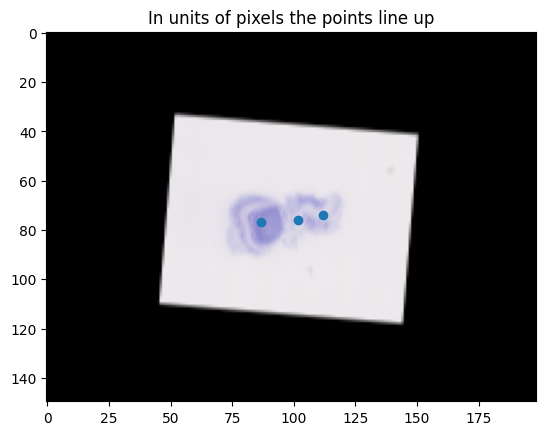

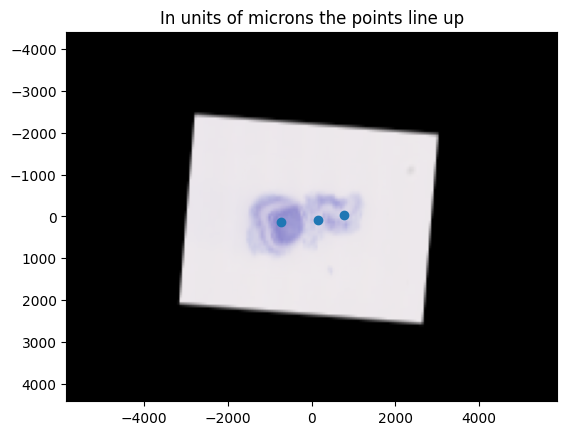

In [12]:
# now let's load the "registered space image"
# in our output this is a vtk file
# here this assumes it is in pixel space
registered_image_file = glob('examples/mouse_serial_section_example/output/Target_registered/Target_to_Target_registered/images/*' + z + '*.vtk')[0]
xregistered,Jregistered,_,_ = emlddmm.read_data(registered_image_file)
# change vtk conventions to our above conventions
J_registered = Jregistered[:,0].transpose(1,2,0)
x_registered = xregistered[-1]
y_registered = xregistered[-2]
dx_registered = (x_registered[1] - x_registered[0], y_registered[1] - y_registered[0])
nx_registered = J_registered.shape[1],J_registered.shape[0]
ox_registered = x_registered[0], y_registered[0]
extent_registered = (x_registered[0]-dx_registered[0]/2, x_registered[-1]+dx_registered[0]/2, y_registered[-1]+dx_registered[1]/2, y_registered[0]-dx_registered[1]/2)
fig,ax = plt.subplots()
ax.imshow(J_registered)
ax.scatter(out[0],out[1])
ax.set_title('In units of pixels the points line up')

# now let's put it back in units of microns
fig,ax = plt.subplots()
ax.imshow(J_registered,extent=extent_registered)
ax.scatter(out[0]*dx_registered[0] + ox_registered[0],out[1]*dx_registered[1] + ox_registered[1])
ax.set_title('In units of microns the points line up')


In [13]:
raise Exception('Stop here, nothing below has been validated')

Exception: Stop here, nothing below has been validated

# Second example, mapping from input space to atlas

In [ ]:
# example, input points 11 map from target_registered to target
point_mapper('examples/mouse_serial_section_example/output/',
             [1.0,2.0],[1.0,5.0], # xy
             z='PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021', # look up from filename
             from_space='Target',to_space='Atlas',
             from_units='microns') # note most important use case will be pixels

In [ ]:
# example, input points 11 map from target_registered to target
transformed_points = point_mapper(
    'examples/mouse_serial_section_example/output/',
    [1.0,2.0],[1.0,5.0], # xy           
    [0.0,1.0],
    from_space='Atlas',to_space='Target_registered'
)

In [ ]:
# example, input points 11 map from target_registered to target
point_mapper('examples/mouse_serial_section_example/output/',
             [1.0,2.0],[1.0,5.0], # xy
             z='PTM902-N7-2021.05.27-16.30.33_PTM902_1_0021', # look up from filename
             from_space='Target',to_space='Atlas',
             from_units='pixels') # note most important use case will be pixels

In [ ]:
# where can we get high resolutoin point information?
# it can be an optional input argument
# NOTE: 
# 